In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, roc_auc_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.experimental import enable_halving_search_cv # noqa
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV
from sklearn.decomposition import PCA


In [2]:
df = pd.read_csv('data/breast-cancer-diagnostic.shuf.lrn.csv')
df.rename(columns=lambda x: x.lstrip(' '), inplace=True) 
df.set_index('ID', inplace=True)
df

,class,radiusMean,textureMean,perimeterMean,areaMean,smoothnessMean,compactnessMean,concavityMean,concavePointsMean,symmetryMean,...,radiusWorst,textureWorst,perimeterWorst,areaWorst,smoothnessWorst,compactnessWorst,concavityWorst,concavePointsWorst,symmetryWorst,fractalDimensionWorst
ID,,,,,,,,,,,,,,,,,,,,,
8611161,False,13.34,15.86,86.49,520.0,0.10780,0.15350,0.116900,0.069870,0.1942,...,15.53,23.19,96.66,614.9,0.1536,0.47910,0.48580,0.17080,0.3527,0.10160
8912280,True,16.24,18.77,108.80,805.1,0.10660,0.18020,0.194800,0.090520,0.1876,...,18.55,25.09,126.90,1031.0,0.1365,0.47060,0.50260,0.17320,0.2770,0.10630
901303,False,16.17,16.07,106.30,788.5,0.09880,0.14380,0.066510,0.053970,0.1990,...,16.97,19.14,113.10,861.5,0.1235,0.25500,0.21140,0.12510,0.3153,0.08960
86973701,False,14.95,18.77,97.84,689.5,0.08138,0.11670,0.090500,0.035620,0.1744,...,16.25,25.47,107.10,809.7,0.0997,0.25210,0.25000,0.08405,0.2852,0.09218
8511133,True,15.34,14.26,102.50,704.4,0.10730,0.21350,0.207700,0.097560,0.2521,...,18.07,19.08,125.10,980.9,0.1390,0.59540,0.63050,0.23930,0.4667,0.09946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8612399,True,18.46,18.52,121.10,1075.0,0.09874,0.10530,0.133500,0.087950,0.2132,...,22.93,27.68,152.20,1603.0,0.1398,0.20890,0.31570,0.16420,0.3695,0.08579
88147202,False,12.62,23.97,81.35,496.4,0.07903,0.07529,0.054380,0.020360,0.1514,...,14.20,31.31,90.67,624.0,0.1227,0.34540,0.39110,0.11800,0.2826,0.09585
897374,False,12.30,19.02,77.88,464.4,0.08313,0.04202,0.007756,0.008535,0.1539,...,13.35,28.46,84.53,544.3,0.1222,0.09052,0.03619,0.03983,0.2554,0.07207


# First thoughts

The breast cancer data set seems to have 285 instances and 30 features which already tells us that there is a high number of features for a small amount of data with a binary target. We first need to check if there are variables that have high correlation with each other in order to remove some of these highly correlated variables to reduce noise.

In [3]:
# checking for missing values
df.isna().any() #no missing values

class                     False
radiusMean                False
textureMean               False
perimeterMean             False
areaMean                  False
smoothnessMean            False
compactnessMean           False
concavityMean             False
concavePointsMean         False
symmetryMean              False
fractalDimensionMean      False
radiusStdErr              False
textureStdErr             False
perimeterStdErr           False
areaStdErr                False
smoothnessStdErr          False
compactnessStdErr         False
concavityStdErr           False
concavePointsStdErr       False
symmetryStdErr            False
fractalDimensionStdErr    False
radiusWorst               False
textureWorst              False
perimeterWorst            False
areaWorst                 False
smoothnessWorst           False
compactnessWorst          False
concavityWorst            False
concavePointsWorst        False
symmetryWorst             False
fractalDimensionWorst     False
dtype: b

# Correlations

The heatmap shows some extremely highly correlated variables. Since the number of features is so high it would probably be best to drop some of the highly correlated columns. Different threshholds could be considered but for 0.8 gives us 17 columns less which is alreadu better than 30 predictors.

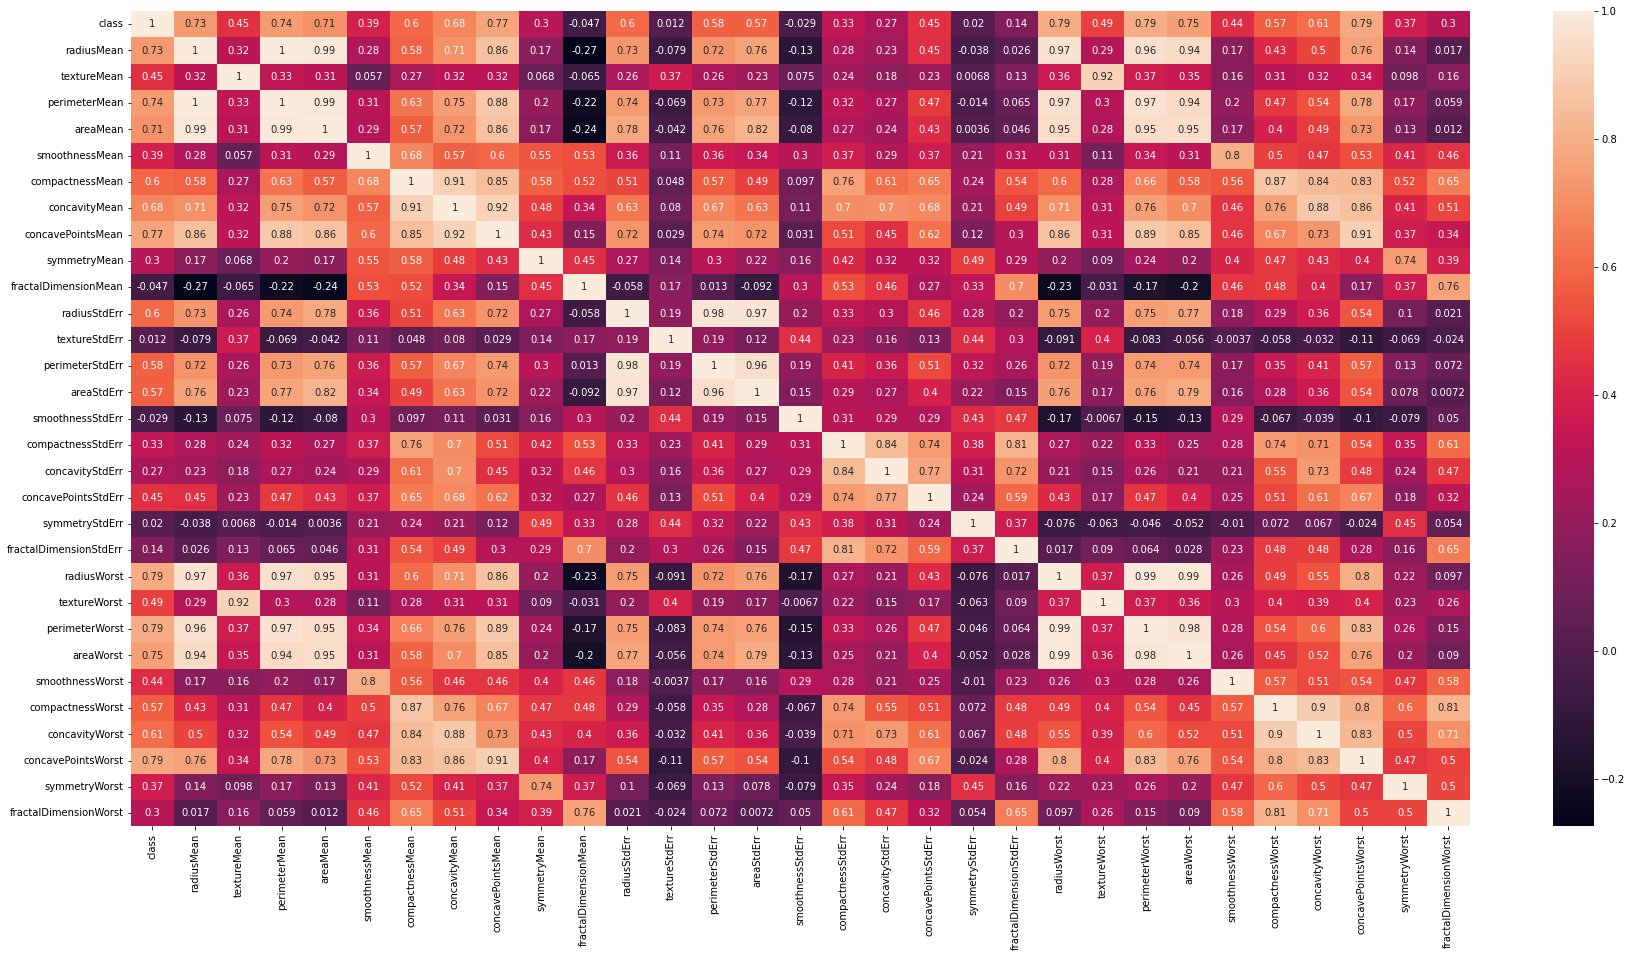

In [4]:
fig, ax = plt.subplots(figsize=(30,15)) 
sns.heatmap(df.corr(), annot=True)
plt.savefig('heatmap.jpg', dpi=300, bbox_inches='tight')

In [5]:
cor_matrix = df.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]

class HighCorrRemover(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, to_drop=to_drop):
        X = X.drop(to_drop, axis=1)
        return X

corr_remove = HighCorrRemover()
df_lowCorr = corr_remove.fit_transform(df)
df_lowCorr.shape    


(285, 14)

# Outliers

Our dataset already has a limited amount of data so dropping any more instances is probably not a good idea. However it is still important to maybe perform a boxplot for our data and see possible outliers. The fact that the boxplot might show some variables as outliers doesn't necessarily mean that a value must be an outlier. Domain knowledge is something that could help us give a definite answer on this issue, but we do not posess such knowledge

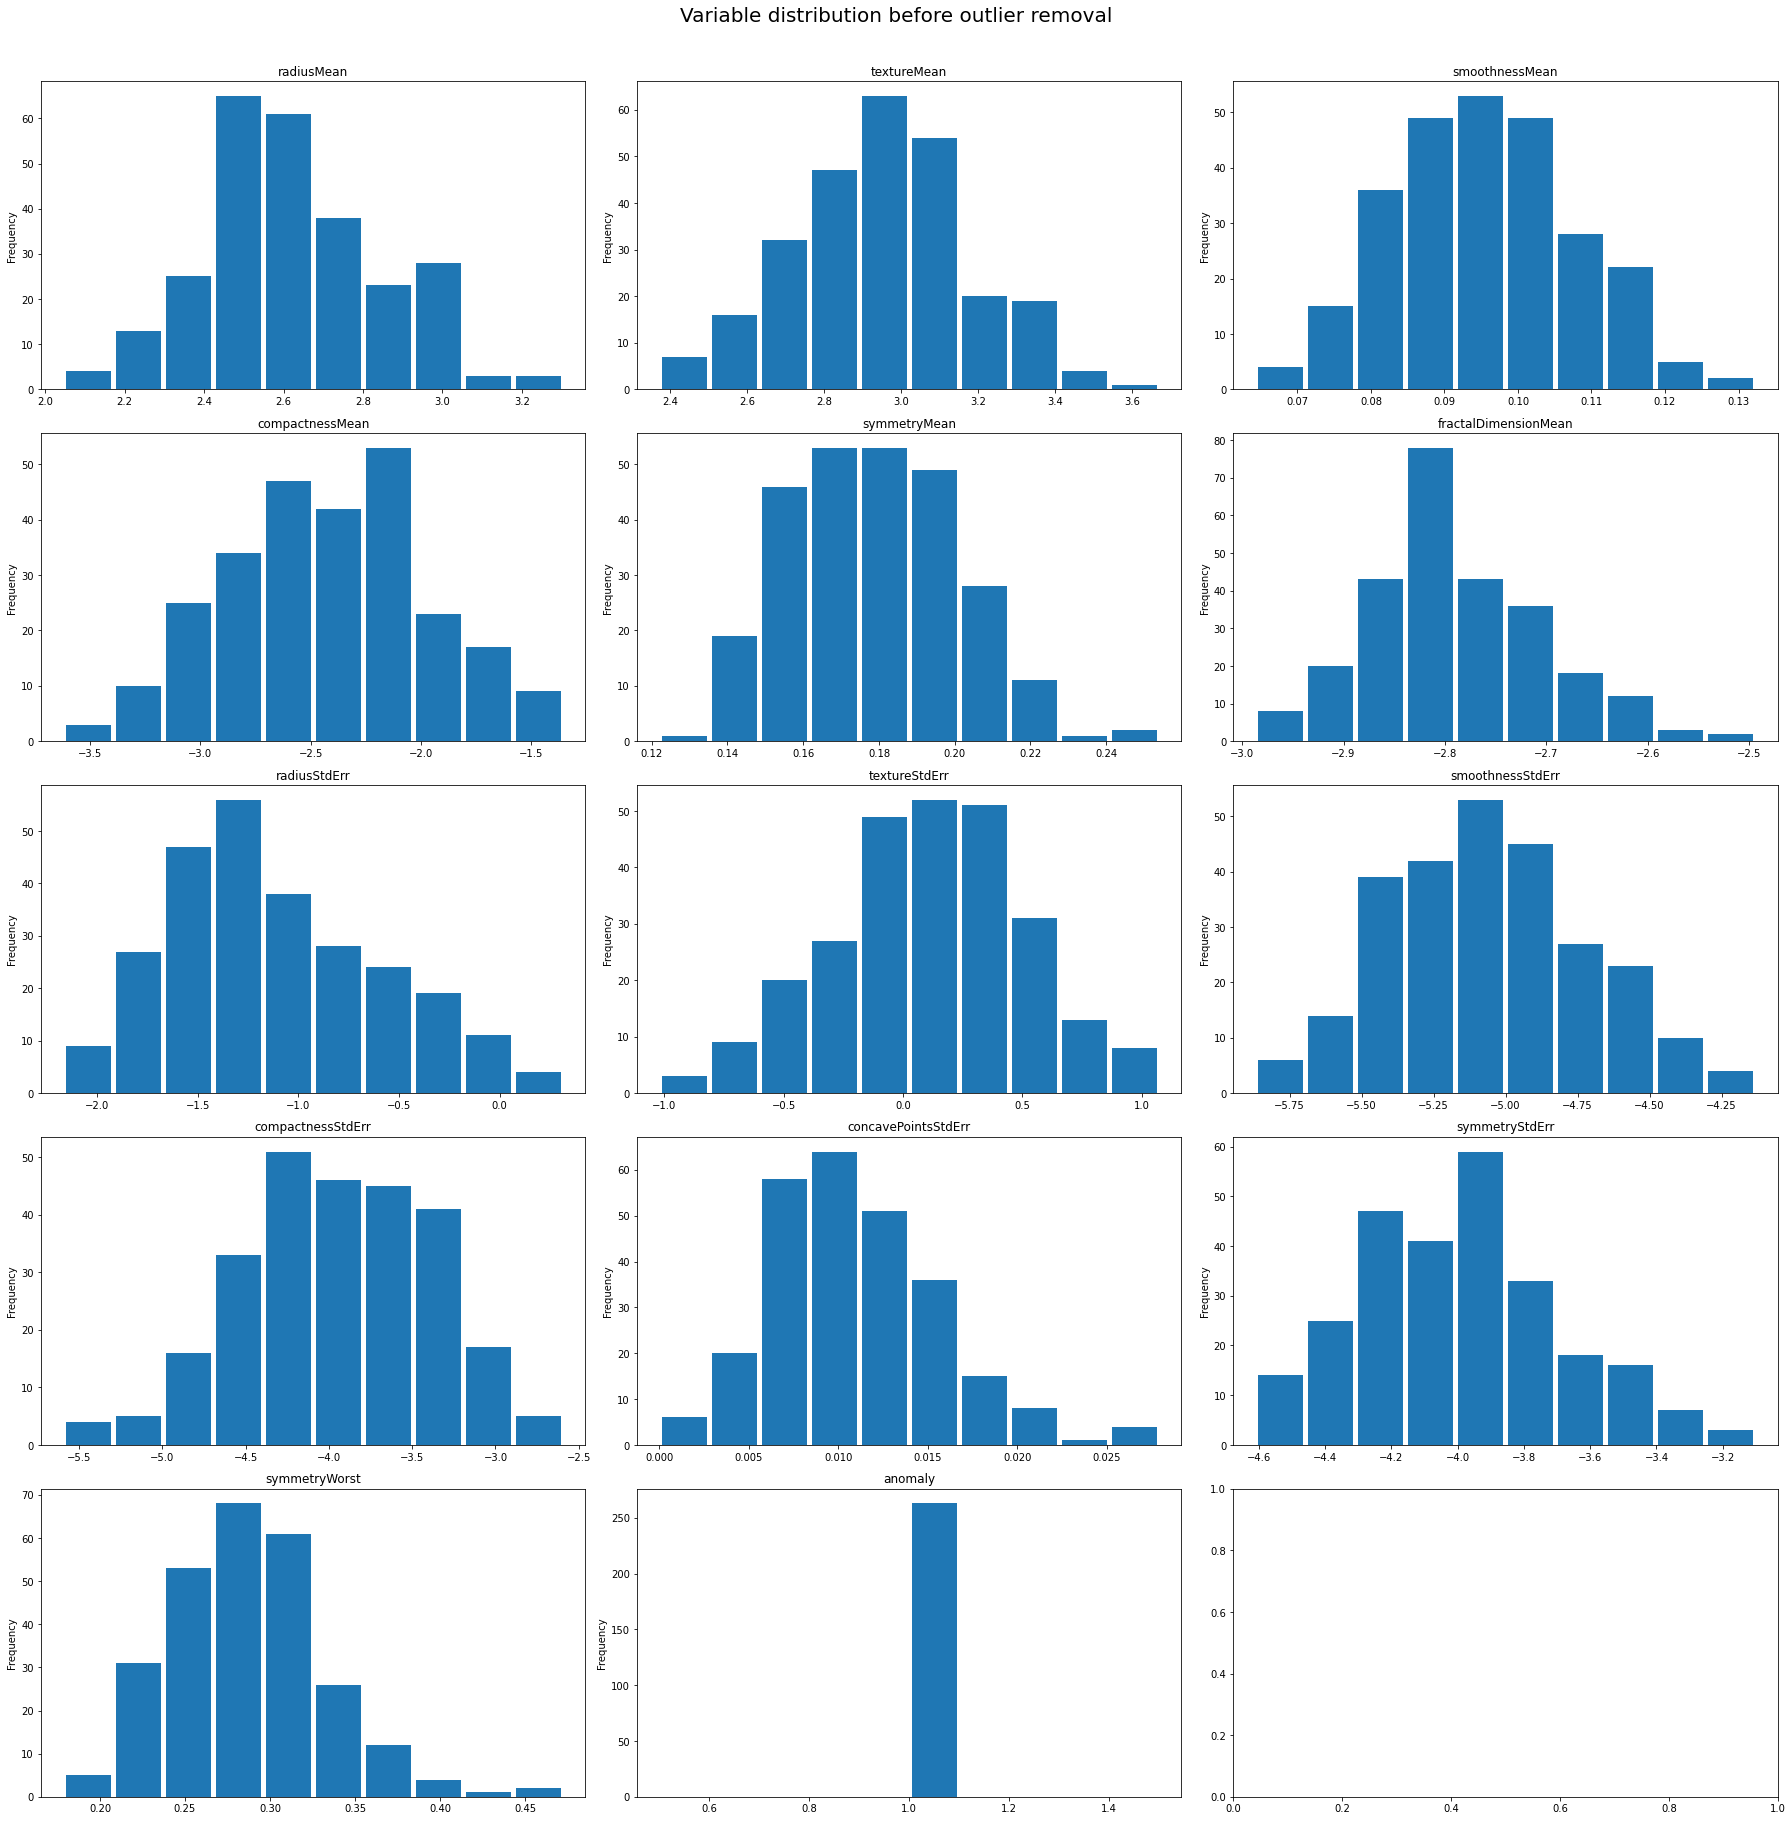

In [36]:
fig, axs = plt.subplots(ncols=3, nrows=5 , figsize= (25,25))
fig.suptitle('Variable distribution before outlier removal', y=1.01, fontsize=20)
for col, ax in zip(df_lowCorr.iloc[: , 1:], axs.ravel()):
    df_lowCorr[col].plot(kind='hist', ax=ax, title=col, rwidth=0.9)

plt.tight_layout()
plt.savefig('Variable distribution pre-outlier removal.jpg', dpi=300, bbox_inches='tight')

In [7]:
columns = list(df_lowCorr.loc[:, df_lowCorr.columns != 'class'].columns)
IF = IsolationForest(random_state=42)
IF.fit(df_lowCorr[columns])
df_lowCorr['anomaly'] = IF.predict(df_lowCorr[columns])
len(df_lowCorr[df_lowCorr['anomaly'] == -1])

22

In [8]:
df_lowCorr = df_lowCorr[df_lowCorr.anomaly != -1]
df_lowCorr.shape

(263, 15)

# After Outlier removal

The Isolation Forest model found 22 anomalies in our data set and already with their removal our distributions are looking much better. However some variables are still skewed. We might consider log-transforming some of this skewed variables.

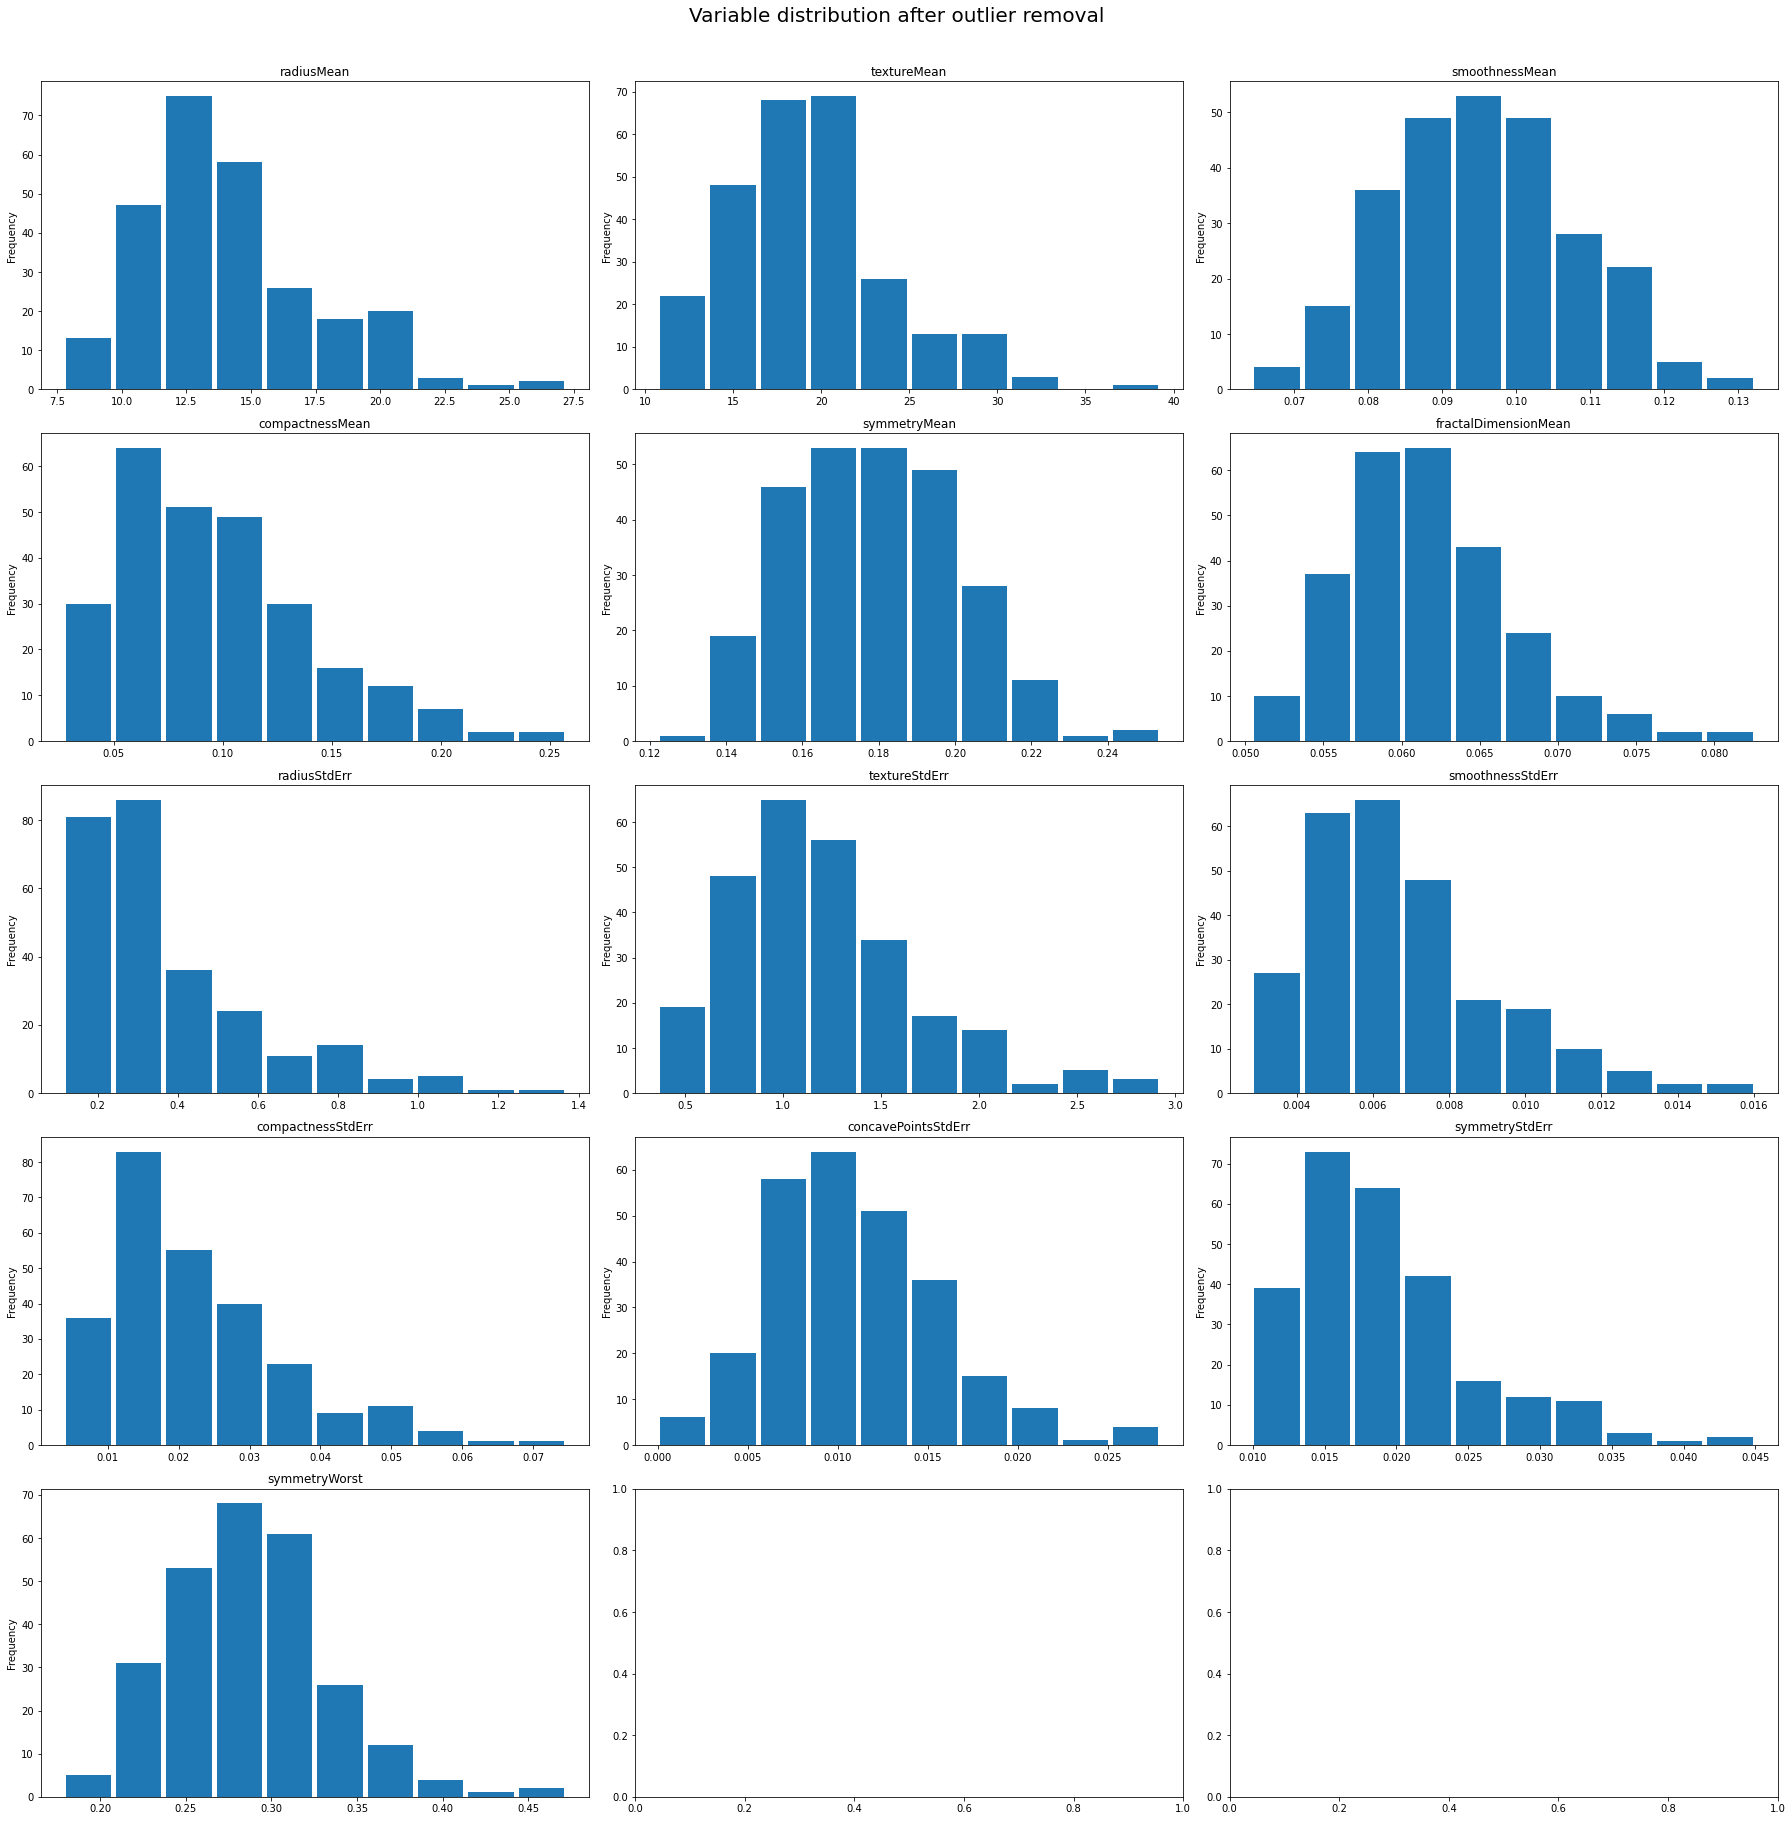

In [9]:
fig, axs = plt.subplots(ncols=3, nrows=5 , figsize= (25,25))
fig.suptitle('Variable distribution after outlier removal', y=1.01, fontsize=20)
for col, ax in zip(df_lowCorr.iloc[: , 1:14], axs.ravel()):
    df_lowCorr[col].plot(kind='hist', ax=ax, title=col, rwidth=0.9)

plt.tight_layout()
plt.savefig('Variable distribution after outlier removal.jpg', dpi=300, bbox_inches='tight')

In [10]:
class LogTransformer (BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
       X.rename(columns=lambda x: x.lstrip(' '), inplace=True)     
       cols_to_log = ['radiusMean', 'textureMean', 'compactnessMean', 
       'radiusStdErr', 'textureStdErr', 'smoothnessStdErr', 'compactnessStdErr'
       , 'symmetryStdErr', 'fractalDimensionMean']
       X[cols_to_log] = np.log(X[cols_to_log])
       return X

log_trans = LogTransformer()
df_lowCorr_transformed = log_trans.fit_transform(df_lowCorr)


# After Log Transforming

After doing the log transform of the data we can see that the data already looks closer to a normal distribution.

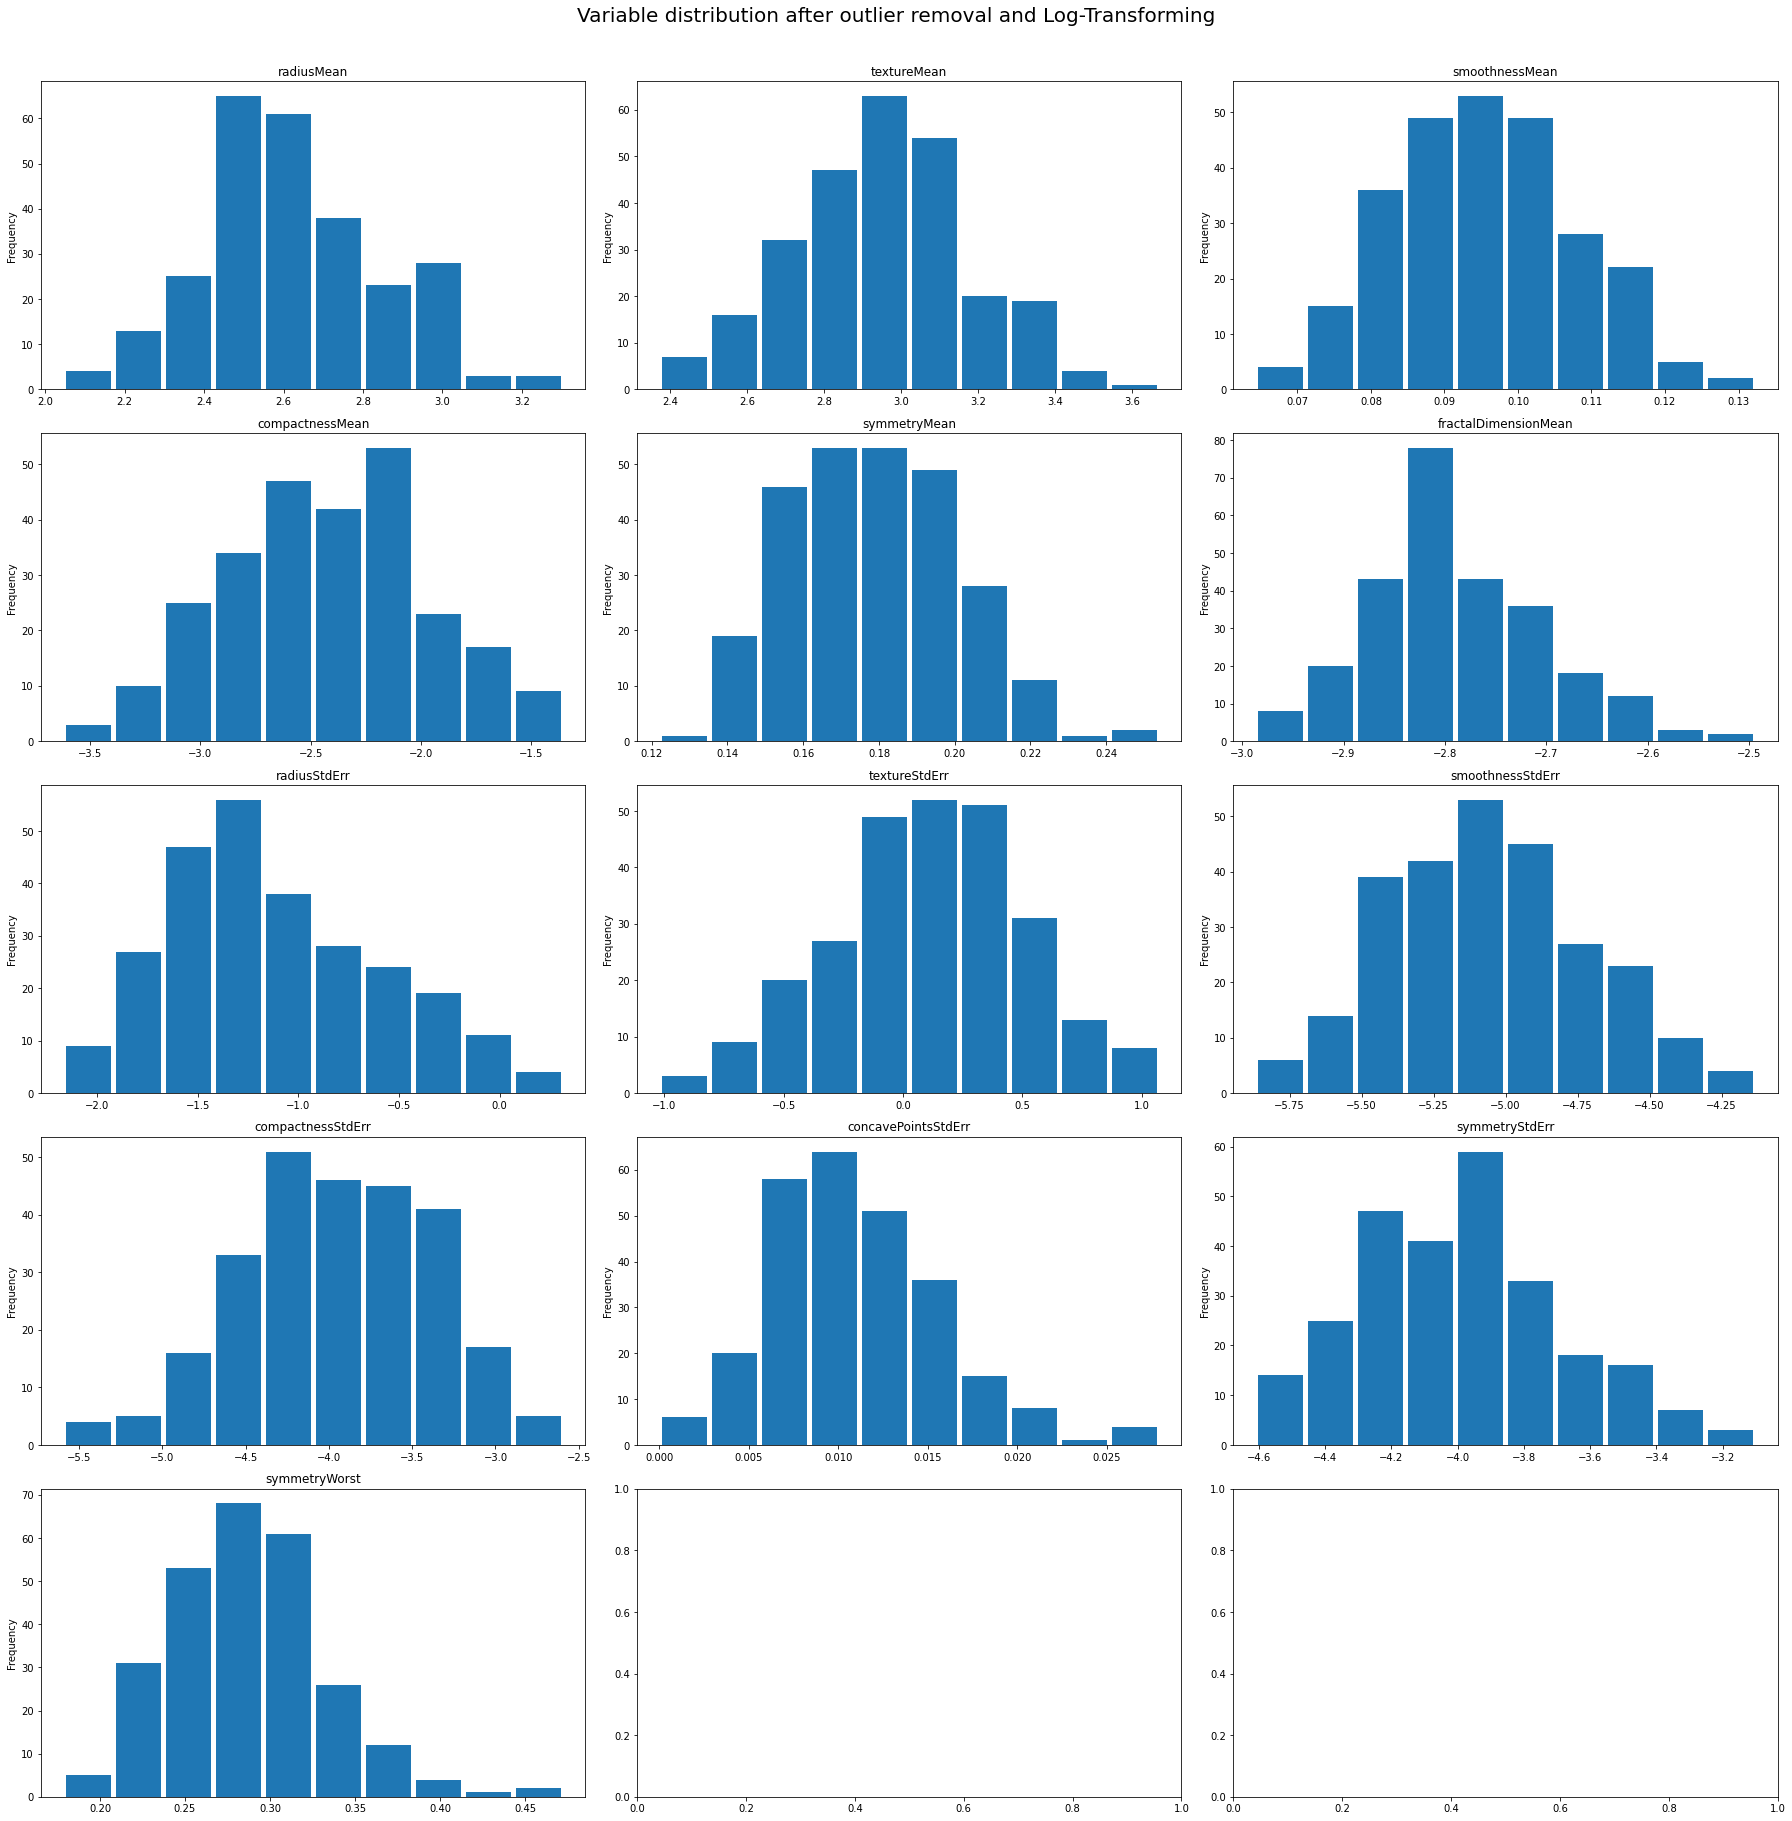

In [11]:
fig, axs = plt.subplots(ncols=3, nrows=5 , figsize= (25,25))
fig.suptitle('Variable distribution after outlier removal and Log-Transforming', y=1.01, fontsize=20)
for col, ax in zip(df_lowCorr_transformed.iloc[: , 1:14], axs.ravel()):
    df_lowCorr_transformed[col].plot(kind='hist', ax=ax, title=col, rwidth=0.9)

plt.tight_layout()
plt.savefig('Variable distribution after outlier removal and Log-Transforming.jpg', dpi=300, bbox_inches='tight')

# Model Selection

First model we're interested to try is the SVM. 

Reference for prediction ( authors found that Support Vector Machine (SVM) was more suitable than the other algorithms and it provided 97.9% accuracy *(N. Fatima, L. Liu, S. Hong and H. Ahmed, "Prediction of Breast Cancer, Comparative Review of Machine Learning Techniques, and Their Analysis," in IEEE Access, vol. 8, pp. 150360-150376, 2020, doi: 10.1109/ACCESS.2020.3016715.)*)

In [12]:
X_transformed = df_lowCorr_transformed.iloc[:, 1:].reset_index()
y_transformed = df_lowCorr_transformed.reset_index()['class'].to_numpy()

X = df_lowCorr.iloc[:, 1:].reset_index()
y = df_lowCorr.reset_index()['class'].to_numpy()

X_train_trans, X_test_trans, y_train_trans, y_test_trans = train_test_split(X_transformed, y_transformed, test_size = 0.2, random_state = 101, stratify=y_transformed)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101, stratify=y)
X_train.drop(['anomaly', 'ID'], inplace=True , axis=1)
X_test.drop(['anomaly', 'ID'], inplace=True , axis=1)

In [13]:
svc_model_trans = SVC()
svc_model_trans.fit(X_train_trans, y_train_trans)
svc_predict_trans = svc_model_trans.predict(X_test_trans)
pd.DataFrame(classification_report(y_test_trans, svc_predict_trans, output_dict=True)).T

,precision,recall,f1-score,support
False,0.702128,0.970588,0.814815,34.000000
True,0.833333,0.263158,0.400000,19.000000
accuracy,0.716981,0.716981,0.716981,0.716981
macro avg,0.767730,0.616873,0.607407,53.000000
weighted avg,0.749164,0.716981,0.666108,53.000000


# Conclusion on Transforming

After training two base models on transformed and non transformed data, we see that there is a reduced accuracy between theese models so we can spare the transforming of the data.

In [14]:
svc_model = SVC()
svc_model.fit(X_train, y_train)
svc_predict = svc_model.predict(X_test)
pd.DataFrame(classification_report(y_test, svc_predict, output_dict=True)).T

,precision,recall,f1-score,support
False,0.894737,1.000000,0.944444,34.000000
True,1.000000,0.789474,0.882353,19.000000
accuracy,0.924528,0.924528,0.924528,0.924528
macro avg,0.947368,0.894737,0.913399,53.000000
weighted avg,0.932473,0.924528,0.922185,53.000000


In [15]:
print("SVM No Log-Transform")
print("Accuracy:", accuracy_score(y_test, svc_predict))
print("F1 Score:", f1_score(y_test, svc_predict))
print("ROC AUC Score:", roc_auc_score(y_test, svc_predict))
print(" ")
print("SVM With Log-Transform")
print("Accuracy:", accuracy_score(y_test, svc_predict_trans))
print("F1 Score:", f1_score(y_test, svc_predict_trans))
print("ROC AUC Score:", roc_auc_score(y_test, svc_predict_trans))

SVM No Log-Transform
Accuracy: 0.9245283018867925
F1 Score: 0.8823529411764706
ROC AUC Score: 0.8947368421052632
 
SVM With Log-Transform
Accuracy: 0.7169811320754716
F1 Score: 0.39999999999999997
ROC AUC Score: 0.6168730650154799


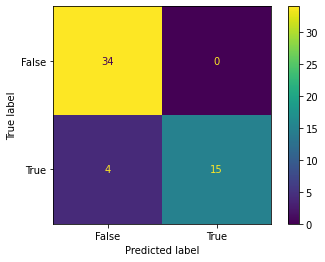

In [16]:
cm = confusion_matrix(y_test, svc_predict, labels=svc_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc_model.classes_)
disp.plot()

# Base Model performance

Base model performance yields 92.45% accuracy, with F1 and ROC_AUC scores of more than 88%

# Using other Classifiers

We will perform the same base model training and prediction with two more classifiers. Other State of The Art algorithms we could use include Random Forest and K-NN *(Y. Khourdifi and M. Bahaj, "Applying Best Machine Learning Algorithms for Breast Cancer Prediction and Classification," 2018 International Conference on Electronics, Control, Optimization and Computer Science (ICECOCS), 2018, pp. 1-5, doi: 10.1109/ICECOCS.2018.8610632.)*


# Results 

RandomForest and KNN are performing very similarly with each other however, SVM retains the best accuracy score.

In [17]:
rf_clf = RandomForestClassifier()
knn_clf = KNeighborsClassifier()

rf_clf.fit(X_train, y_train)
knn_clf.fit(X_train, y_train)

rf_pred = rf_clf.predict(X_test)
knn_pred = knn_clf.predict(X_test)

print("RandomForestClassifier :")
print("Accuracy:", accuracy_score(y_test, rf_pred))
print("F1 Score:", f1_score(y_test, rf_pred))
print("ROC AUC Score:", roc_auc_score(y_test, rf_pred))
print(" ")
print("K-Nearest-Neighbors Classifier :")
print("Accuracy:", accuracy_score(y_test, knn_pred))
print("F1 Score:", f1_score(y_test, knn_pred))
print("ROC AUC Score:", roc_auc_score(y_test, knn_pred))

RandomForestClassifier :
Accuracy: 0.9056603773584906
F1 Score: 0.8717948717948718
ROC AUC Score: 0.903250773993808
 
K-Nearest-Neighbors Classifier :
Accuracy: 0.8867924528301887
F1 Score: 0.8421052631578947
ROC AUC Score: 0.8769349845201238


# Improving model performance

So far we ran predictions with the default set of hyperparameters for each model. We will now perform Grid Cearch CV in order to find the best hyperparameters for each model.

## SVM

For SVM we consider the following hyperparameters:

* C: It is the regularization parameter, C, of the error term.
* kernel: It specifies the kernel type to be used in the algorithm. It can be ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’, or callable. The default value is ‘rbf’.
* degree: It is the degree of the polynomial kernel function (‘poly’) and is ignored by all other kernels. The default value is 3.
* gamma: It is the kernel coefficient for ‘rbf’, ‘poly’, and ‘sigmoid’. If gamma is ‘auto’, then 1/n_features will be used instead.

For C and gamma we consider the following value range:

C = [$2^{-5}, 2^{-3},2^{2},2^{6},2^{8}$] (rounded) \
gamma = [$2^{-8}, 2^{-4}, 2^{2}$] (rounded)

Reference: *Hsu, Chih-wei & Chang, Chih-chung & Lin, Chih-Jen. (2003). A Practical Guide to Support Vector Classification Chih-Wei Hsu, Chih-Chung Chang, and Chih-Jen Lin.*


In [18]:
C_param = [0.03, 0.1, 4, 64, 256]
gamma_param = [0.0004, 0.06, 4]
param_grid_svm = { 'C': C_param,
                'kernel':['rbf','sigmoid','linear'],
                'gamma': gamma_param}
                
grid_svm = GridSearchCV(SVC(random_state=42), param_grid_svm, n_jobs=-1)
grid_svm.fit(X_train, y_train)

print(grid_svm.best_params_)
print(grid_svm.score(X_test, y_test))

{'C': 64, 'gamma': 0.06, 'kernel': 'rbf'}
0.9433962264150944


# PCA

## SVM

Since there are already a lot of variables we decide to perform PCA and observe that we can have 95% of the explained variables with 4 Principal components. After training a model with PC we observe that the accuracy is lower so we decide to keep the original data.

## RandomForest and KNN

After training a reduced model with these algorithms we observe an increased score on both of them however not by a significant amount.

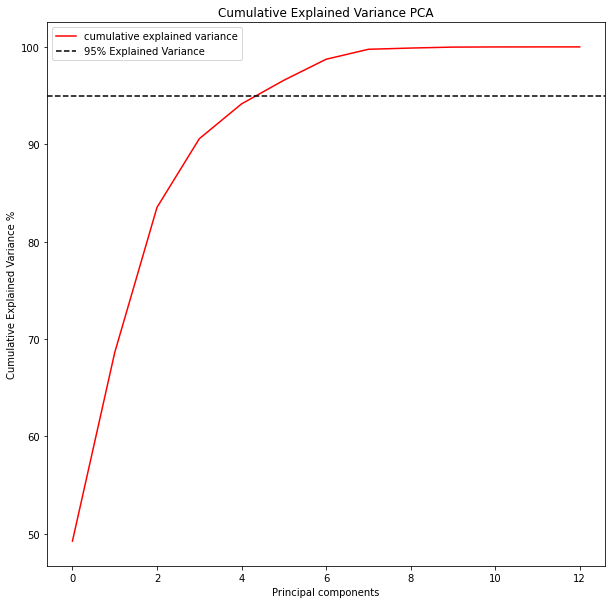

In [35]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_) * 100
d = [n for n in range(len(cumsum))]
plt.figure(figsize=(10,10))
plt.plot(d, cumsum, color='red', label='cumulative explained variance')
plt.title('Cumulative Explained Variance PCA')
plt.xlabel('Principal components')
plt.ylabel('Cumulative Explained Variance %')
plt.axhline(y=95, color='k', linestyle='--', label = '95% Explained Variance')
plt.legend(loc='best')
plt.savefig('Cumulative explained variance PCA.jpg', dpi=300, bbox_inches='tight')

In [20]:
pca = PCA(.95)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [21]:
svc_model_pca = SVC()
svc_model_pca.fit(X_train_pca, y_train)
svc_predict_pca = svc_model_pca.predict(X_test_pca)

print("Accuracy (SVM):", accuracy_score(y_test, svc_predict_pca))
print("F1 Score (SVM):", f1_score(y_test, svc_predict_pca))
print("ROC AUC Score (SVM):", roc_auc_score(y_test, svc_predict_pca))

Accuracy (SVM): 0.9056603773584906
F1 Score (SVM): 0.8648648648648649
ROC AUC Score (SVM): 0.891640866873065


In [22]:
param_grid_svm_pca = { 'C': C_param,
                'kernel':['rbf','sigmoid','linear'],
                'gamma': gamma_param}
                
grid_svm_pca = GridSearchCV(SVC(random_state=42), param_grid_svm_pca, n_jobs=-1)
grid_svm_pca.fit(X_train_pca, y_train)

print(grid_svm_pca.best_params_)
print(grid_svm_pca.score(X_test_pca, y_test))

{'C': 4, 'gamma': 0.06, 'kernel': 'rbf'}
0.8867924528301887


In [23]:
rf_clf_pca = RandomForestClassifier()
knn_clf_pca = KNeighborsClassifier()

rf_clf_pca.fit(X_train_pca, y_train)
knn_clf_pca.fit(X_train_pca, y_train)

rf_pred_pca = rf_clf_pca.predict(X_test_pca)
knn_pred_pca = knn_clf_pca.predict(X_test_pca)

print("RandomForestClassifier :")
print("Accuracy:", accuracy_score(y_test, rf_pred_pca))
print("F1 Score:", f1_score(y_test, rf_pred_pca))
print("ROC AUC Score:", roc_auc_score(y_test, rf_pred_pca))
print(" ")
print("K-Nearest-Neighbors Classifier :")
print("Accuracy:", accuracy_score(y_test, knn_pred_pca))
print("F1 Score:", f1_score(y_test, knn_pred_pca))
print("ROC AUC Score:", roc_auc_score(y_test, knn_pred_pca))

RandomForestClassifier :
Accuracy: 0.9056603773584906
F1 Score: 0.8717948717948718
ROC AUC Score: 0.903250773993808
 
K-Nearest-Neighbors Classifier :
Accuracy: 0.9056603773584906
F1 Score: 0.8717948717948718
ROC AUC Score: 0.903250773993808


## RandomForest GridSearch


In [24]:
param_grid_rf = { 
    'n_estimators': [100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [3,4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid=param_grid_rf, n_jobs=-1)
grid_rf.fit(X_train, y_train)

print(grid_rf.best_params_)
print(grid_rf.score(X_test, y_test))

{'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 100}
0.9056603773584906


## KNN GridSearch

After performing hyperparameter tuning for KNN we observe the same score as in SVM.

In [25]:
param_grid_knn = { 'n_neighbors' : [5,7,9,11,13,15],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}

grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, n_jobs=-1)

grid_knn.fit(X_train, y_train)

print(grid_knn.best_params_)
print(grid_knn.score(X_test, y_test))

{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'uniform'}
0.9433962264150944


# Model Showdown SVM vs KNN

Since these two models had an equal scoring after tuning, we will use both of them on the test data and see which one performs best. So far they both have a score of 94.34%

In [26]:
svc_model_final = SVC(C=64, gamma=0.06, kernel='rbf')
svc_model_final.fit(X_train, y_train)
svc_predict_final = svc_model_final.predict(X_test)

knn_final = KNeighborsClassifier(metric='manhattan', n_neighbors=5, weights='uniform')
knn_final.fit(X_train, y_train)
knn_final_predict = knn_final.predict(X_test)


print("SVM :")
print("Accuracy:", accuracy_score(y_test, svc_predict_final))
print("F1 Score:", f1_score(y_test, svc_predict_final))
print("ROC AUC Score:", roc_auc_score(y_test, svc_predict_final))
print(" ")
print("K-Nearest-Neighbors Classifier :")
print("Accuracy:", accuracy_score(y_test, knn_final_predict))
print("F1 Score:", f1_score(y_test, knn_final_predict))
print("ROC AUC Score:", roc_auc_score(y_test, knn_final_predict))

SVM :
Accuracy: 0.9433962264150944
F1 Score: 0.9230769230769231
ROC AUC Score: 0.9442724458204333
 
K-Nearest-Neighbors Classifier :
Accuracy: 0.9433962264150944
F1 Score: 0.918918918918919
ROC AUC Score: 0.9326625386996905


# Best Model Performance on Test Data

In [27]:
df_test = pd.read_csv('data/breast-cancer-diagnostic.shuf.tes.csv')
df_test.rename(columns=lambda x: x.lstrip(' '), inplace=True) 
df_test.set_index('ID', inplace=True)
df_test

,radiusMean,textureMean,perimeterMean,areaMean,smoothnessMean,compactnessMean,concavityMean,concavePointsMean,symmetryMean,fractalDimensionMean,...,radiusWorst,textureWorst,perimeterWorst,areaWorst,smoothnessWorst,compactnessWorst,concavityWorst,concavePointsWorst,symmetryWorst,fractalDimensionWorst
ID,,,,,,,,,,,,,,,,,,,,,
88299702,23.210,26.97,153.50,1670.0,0.09509,0.16820,0.19500,0.12370,0.1909,0.06309,...,31.010,34.51,206.00,2944.0,0.14810,0.41260,0.58200,0.25930,0.3103,0.08677
911201,14.530,13.98,93.86,644.2,0.10990,0.09242,0.06895,0.06495,0.1650,0.06121,...,15.800,16.93,103.10,749.9,0.13470,0.14780,0.13730,0.10690,0.2606,0.07810
90312,19.550,23.21,128.90,1174.0,0.10100,0.13180,0.18560,0.10210,0.1989,0.05884,...,20.820,30.44,142.00,1313.0,0.12510,0.24140,0.38290,0.18250,0.2576,0.07602
86135502,19.020,24.59,122.00,1076.0,0.09029,0.12060,0.14680,0.08271,0.1953,0.05629,...,24.560,30.41,152.90,1623.0,0.12490,0.32060,0.57550,0.19560,0.3956,0.09288
88411702,13.750,23.77,88.54,590.0,0.08043,0.06807,0.04697,0.02344,0.1773,0.05429,...,15.010,26.34,98.00,706.0,0.09368,0.14420,0.13590,0.06106,0.2663,0.06321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92751,7.760,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,0.1587,0.05884,...,9.456,30.37,59.16,268.6,0.08996,0.06444,0.00000,0.00000,0.2871,0.07039
915186,9.268,12.87,61.49,248.7,0.16340,0.22390,0.09730,0.05252,0.2378,0.09502,...,10.280,16.38,69.05,300.2,0.19020,0.34410,0.20990,0.10250,0.3038,0.12520
8913,12.890,13.12,81.89,515.9,0.06955,0.03729,0.02260,0.01171,0.1337,0.05581,...,13.620,15.54,87.40,577.0,0.09616,0.11470,0.11860,0.05366,0.2309,0.06915


In [28]:
corr_remove_tes = HighCorrRemover()
df_test = corr_remove_tes.fit_transform(df_test)
df_test.shape 

(284, 13)

In [29]:
X_kaggle_test = df_test.reset_index()
X_kaggle_test.drop('ID', inplace=True, axis=1)
X_kaggle_test

,radiusMean,textureMean,smoothnessMean,compactnessMean,symmetryMean,fractalDimensionMean,radiusStdErr,textureStdErr,smoothnessStdErr,compactnessStdErr,concavePointsStdErr,symmetryStdErr,symmetryWorst
0,23.210,26.97,0.09509,0.16820,0.1909,0.06309,1.0580,0.9635,0.006428,0.02863,0.017160,0.01590,0.3103
1,14.530,13.98,0.10990,0.09242,0.1650,0.06121,0.3060,0.7213,0.006133,0.01251,0.011360,0.02207,0.2606
2,19.550,23.21,0.10100,0.13180,0.1989,0.05884,0.6107,2.8360,0.011240,0.04097,0.034410,0.02768,0.2576
3,19.020,24.59,0.09029,0.12060,0.1953,0.05629,0.5495,0.6636,0.003872,0.01842,0.012000,0.01964,0.3956
4,13.750,23.77,0.08043,0.06807,0.1773,0.05429,0.4347,1.0570,0.004351,0.02667,0.010070,0.02598,0.2663
...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,7.760,24.54,0.05263,0.04362,0.1587,0.05884,0.3857,1.4280,0.007189,0.00466,0.000000,0.02676,0.2871
280,9.268,12.87,0.16340,0.22390,0.2378,0.09502,0.4076,1.0930,0.009783,0.04542,0.021880,0.02542,0.3038
281,12.890,13.12,0.06955,0.03729,0.1337,0.05581,0.1532,0.4690,0.004731,0.01345,0.005905,0.01619,0.2309
282,9.567,15.91,0.08464,0.04087,0.1551,0.06403,0.2152,0.8301,0.011640,0.01040,0.009623,0.02383,0.2757


In [30]:
X_train

,radiusMean,textureMean,smoothnessMean,compactnessMean,symmetryMean,fractalDimensionMean,radiusStdErr,textureStdErr,smoothnessStdErr,compactnessStdErr,concavePointsStdErr,symmetryStdErr,symmetryWorst
145,2.556452,2.753661,0.07818,-2.345493,0.1432,-2.824303,-1.233402,0.328584,-5.048649,-3.228674,0.017740,-3.974963,0.1999
26,2.352327,3.005187,0.11220,-2.037916,0.1922,-2.553357,-1.097813,0.620576,-4.432899,-3.284215,0.015440,-3.777929,0.2383
101,2.412336,3.063858,0.10180,-2.817084,0.1615,-2.789694,-1.250017,0.517603,-4.975075,-4.662587,0.006159,-3.614143,0.2976
222,2.679651,2.614472,0.09832,-2.417098,0.1739,-2.875286,-0.875869,-0.472086,-5.307762,-4.010739,0.008648,-4.174037,0.2626
236,3.003700,2.978586,0.08020,-2.457603,0.1928,-2.976714,-0.523404,-0.376440,-5.395710,-4.285989,0.012470,-3.819900,0.3055
...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,2.479056,3.069447,0.09768,-2.544784,0.1688,-2.781589,-1.165393,-0.080451,-4.853247,-3.686083,0.007711,-4.359874,0.2438
169,2.701361,3.114848,0.09947,-1.502828,0.2041,-2.673939,-1.374366,-0.133646,-4.966858,-2.778526,0.022340,-4.200372,0.2866
34,2.463002,2.687167,0.08099,-2.337073,0.1499,-2.694443,-1.648179,-0.443634,-4.964420,-3.240099,0.015280,-3.789805,0.2604
23,2.985682,3.070840,0.09383,-2.035616,0.2094,-2.885802,-0.045730,0.170586,-4.990245,-3.451754,0.017120,-3.964896,0.3070


In [31]:
df_sol = pd.read_csv('data/breast-cancer-diagnostic.shuf.sol.ex.csv')
df_sol

,ID,class
0,88299702,True
1,911201,True
2,90312,True
3,86135502,True
4,88411702,True
...,...,...
279,92751,True
280,915186,True
281,8913,True
282,882488,True


# Conclusion Equal accuracy

Both models achieved 100% accuracy

In [32]:
svc_test_predict = svc_model_final.predict(X_kaggle_test)
print("SVM")
print("Accuracy:", accuracy_score(df_sol['class'], svc_test_predict))
print(" ")
print("KNN: ")
knn_test_predict = knn_final.predict(X_kaggle_test)
print("Accuracy:", accuracy_score(df_sol['class'], knn_test_predict))

SVM
Accuracy: 1.0
 
KNN: 
Accuracy: 1.0


In [33]:
hand_in = pd.DataFrame(df_sol['ID'])
hand_in['class'] = svc_test_predict
hand_in

,ID,class
0,88299702,True
1,911201,True
2,90312,True
3,86135502,True
4,88411702,True
...,...,...
279,92751,True
280,915186,True
281,8913,True
282,882488,True


In [34]:
hand_in.to_csv('breast-cancer-submission-g11.csv', index=False)